# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1 - df_test 04-19to04-19.feather', '1.1 - df_train.feather', '1.1 - df_val 01-19to03-19.feather', '1.1 - df_test 04-19to05-19.feather', '1.1 - df_train only 2018 without nulls.feather', '1.1 - df_train with nan.feather']


## Loading training and validation datasets

In [3]:
df = pd.read_feather(os.path.join(path, "1.1 - df_train only 2018 without nulls.feather"))
df_val = pd.read_feather(os.path.join(path, "1.1 - df_val 01-19to03-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [5]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [6]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [7]:
# using only last year
df_train = df[df["FECHA_SINI"] < "2018-10-01"].copy()
df_opt = df[df["FECHA_SINI"] >= "2018-10-01"].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-01 00:00:00 2018-09-30 00:00:00
2018-10-01 00:00:00 2018-12-31 00:00:00


In [8]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [9]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"]

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [10]:
X_full_train = df.drop(to_drop, axis=1)
y_full_train = df["EXISTE_FRAUDE"]

In [11]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [12]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

360463, 120551
360463, 120551


In [13]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.0035287949109894775, 0.003973422037146104)

## short optimization

In [58]:
'''from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))
'''
#set_rf_samples(60000)

'from sklearn.ensemble import forest\ndef set_rf_samples(n):\n    """ Changes Scikit learn\'s random forests to give each tree a random sample of\n    n random rows.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n))\n\ndef reset_rf_samples():\n    """ Undoes the changes produced by set_rf_samples.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n_samples))\n'

## Defining grid configuration

In [14]:
from sklearn.utils.class_weight import compute_class_weight

In [15]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([  0.50182676, 137.35408338])

In [16]:
rf_params = {
#    "n_estimators": [40, 100],
#    "min_samples_leaf": [3, 7],
#    "max_depth": [3, 5, 10],
#    "max_features": ['sqrt', 0.5],
    "class_weight": [{0:1, 1:20}, {0:1, 1:18}, {0:1, 1:25}]
}

In [17]:
# using without grid
rf = RandomForestClassifier(n_estimators=40, max_features="sqrt",
                            min_samples_leaf=55, random_state=random_state, n_jobs=-1)
# rf.fit(X_full_train, y_full_train)

In [18]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt 
clf = GridSearch(rf, param_grid=rf_params)
clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring="recall", verbose=True)

Comparing 3 parameter setting(s) using 8 CPU thread(s) ( 1 job(s) per thread ).


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [19]:
print("Best Config:")
print(clf.best_params, clf.best_score)

Best Config:
{'class_weight': {0: 1, 1: 25}} 0.6075156576200418


In [20]:
print("Grid scores:")
for params, score in zip(clf.params, clf.scores):
    print("%0.3f for %r" % (score, params))

Grid scores:
0.608 for {'class_weight': {0: 1, 1: 25}}
0.574 for {'class_weight': {0: 1, 1: 20}}
0.564 for {'class_weight': {0: 1, 1: 18}}


In [21]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [22]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4055348589675359, 0.8476421235460161)

In [23]:
confusion_matrix(y_val, y_val_pred)

array([[105766,    957],
       [   160,    381]])

In [65]:
confusion_matrix(y_val, y_val_pred)

array([[106303,    420],
       [   259,    282]])

## dumping best current config

In [208]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worst</h3>

In [24]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':clf.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
11,cond_C12,0.100492
88,TIPO_EXPED,0.099174
43,preg_15,0.057843
29,total_condicion,0.047763
9,cond_C10,0.047684
10,cond_C11,0.046140
54,preg_33,0.043075
52,preg_31,0.034657
30,es_gte_5,0.032194
6,cond_32,0.031895


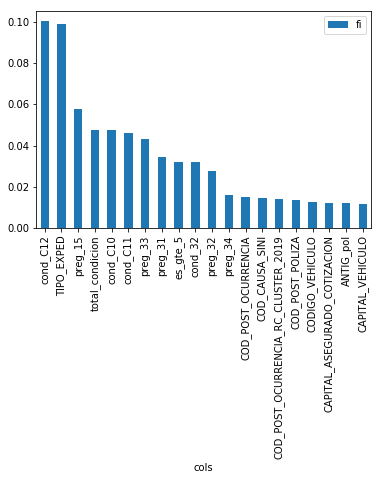

In [25]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [26]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 39 of 152


In [27]:
to_keep.remove("es_gte_5")
to_keep

['cond_C12',
 'TIPO_EXPED',
 'preg_15',
 'total_condicion',
 'cond_C10',
 'cond_C11',
 'preg_33',
 'preg_31',
 'cond_32',
 'preg_32',
 'preg_34',
 'COD_POST_OCURRENCIA',
 'COD_CAUSA_SINI',
 'COD_POST_OCURRENCIA_RC_CLUSTER_2019',
 'COD_POST_POLIZA',
 'CODIGO_VEHICULO',
 'CAPITAL_ASEGURADO_COTIZACION',
 'ANTIG_pol',
 'CAPITAL_VEHICULO',
 'FECHA_SINI_Dayofyear',
 'COD_POST_POLIZA_RC_CLUSTER_2019',
 'FECHA_SINI_Elapsed',
 'OCUPACION_ASEG',
 'COD_POST_OCURRENCIA_DP_CLUSTER_2019',
 'COD_PROD',
 'cond_C5',
 'CANT_RENOVACION',
 'FECHA_SINI_Week',
 'COD_POST_POLIZA_DP_CLUSTER_2019',
 'FECHA_SINI_Day',
 'CONDICION_ROBO_EXP50',
 'cond_37',
 'cond_12',
 'COD_POST_POLIZA_RT_CLUSTER_2019',
 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
 'COD_ZONA_ROBO',
 'dias_entre_denu_y_sini',
 'FECHA_SINI_Dayofweek']

In [28]:
# best model
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [29]:
X_train_red = X_train[to_keep].copy()

In [30]:
print(len(X_train_red.columns))

38


### Training again with less features

In [31]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [32]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4073078989790435, 0.8458686551220589)

In [33]:
confusion_matrix(y_val, y_val_pred)

array([[105782,    941],
       [   162,    379]])

In [34]:
confusion_matrix(y_val, y_val_pred)

array([[105782,    941],
       [   162,    379]])

In [35]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
2,preg_15,0.104530
8,cond_32,0.099017
1,TIPO_EXPED,0.097104
4,cond_C10,0.086392
3,total_condicion,0.067203
6,preg_33,0.053597
7,preg_31,0.038482
0,cond_C12,0.031414
9,preg_32,0.027154
5,cond_C11,0.021077


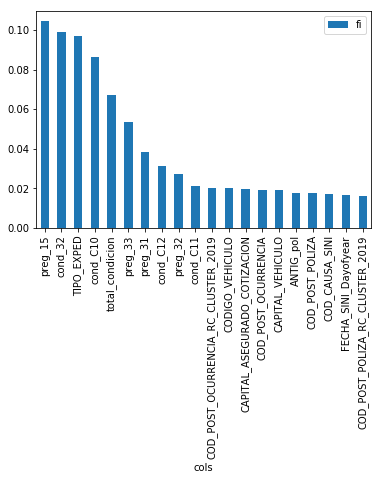

In [36]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [78]:
# best columns used
rf_fi["cols"].values

array(['total_condicion', 'cond_C10', 'TIPO_EXPED', 'preg_33', 'cond_32',
       'cond_C11', 'CODIGO_VEHICULO', 'preg_32', 'preg_15', 'cond_C12',
       'CAPITAL_ASEGURADO_COTIZACION',
       'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'CAPITAL_VEHICULO',
       'FECHA_SINI_Dayofyear', 'COD_POST_POLIZA', 'OCUPACION_ASEG',
       'ANTIG_pol', 'preg_34', 'COD_POST_OCURRENCIA',
       'FECHA_SINI_Elapsed', 'COD_PROD',
       'COD_POST_POLIZA_RC_CLUSTER_2019', 'CONDICION_ROBO_EXP50',
       'CANT_RENOVACION', 'TIPO_SINIESTRO',
       'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'FECHA_SINI_Day',
       'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'preg_31',
       'FECHA_SINI_Week', 'SEGMENTO', 'preg_28',
       'COD_POST_POLIZA_DP_CLUSTER_2019', 'FECHA_SINI_Dayofweek',
       'COD_ZONA_ROBO', 'COD_POST_POLIZA_RT_CLUSTER_2019',
       'FECHA_SINI_Month', 'cond_C5', 'COD_CAUSA_SINI'], dtype=object)

# final model

In [209]:
# reset_rf_samples()

## full features final model

In [159]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [160]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.554, 0.998


In [161]:
confusion_matrix(y_val, y_val_pred)

array([[105994,    747],
       [    37,    486]])

## red features final model

In [40]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [41]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.412, 0.977


In [42]:
confusion_matrix(y_val, y_val_pred)

array([[105809,    914],
       [   163,    378]])

In [130]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[105921,    802],
       [   169,    372]])

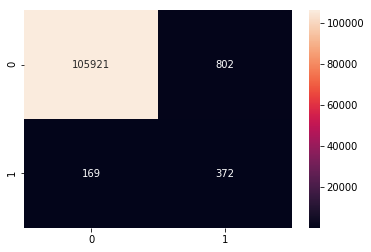

In [131]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [110]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3801229508196721,0.8380111222337413)


In [128]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[105683,   1040],
       [   170,    371]])

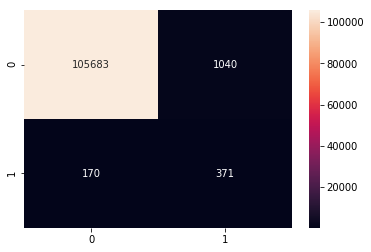

In [129]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [112]:
path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
model_file = os.path.join(path_to_save, "1.1.a (Model) - Model Optimization recall - class_weight balanced - time sorted - valid score (0.452, 0.978).pickle")

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [113]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [114]:
# merging list input & target
full_cols = list(to_keep) + ["EXISTE_FRAUDE"]
print(full_cols)

['cond_C12', 'preg_33', 'total_condicion', 'cond_C10', 'cond_32', 'TIPO_EXPED', 'cond_C11', 'preg_15', 'preg_31', 'preg_32', 'COD_POST_OCURRENCIA', 'preg_34', 'COD_CAUSA_SINI', 'COD_POST_POLIZA', 'COD_POSTAL', 'cond_12', 'CAPITAL_VEHICULO', 'CODIGO_VEHICULO', 'ANTIG_pol', 'FECHA_SINI_Dayofyear', 'COD_PROD', 'FECHA_SINI_Elapsed', 'OCUPACION_ASEG', 'CANT_RENOVACION', 'CAPITAL_ASEGURADO_COTIZACION', 'FECHA_SINI_Week', 'COD_ZONA_ROBO', 'FECHA_SINI_Day', 'preg_27', 'dias_entre_denu_y_sini', 'cond_C2', 'FECHA_SINI_Month', 'FECHA_SINI_Dayofweek', 'SEGMENTO', 'CONV_COMISIONARIO', 'COD_ZONA_RC', 'TIPO_SINIESTRO', 'EXISTE_FRAUDE']


In [115]:
path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
columns_file = os.path.join(path_to_save, "1.1.a (COLUMNS) - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [127]:
# saving for example a few rows to implement the model
path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
sample_file = os.path.join(path_to_save, "1.1.a. (sample)  - dataset example to predict model.csv")

df_example = X_val.loc[:, to_keep][-50:]
df_example["EXISTE_FRAUDE"] = y_val[-50:]
df_example.to_csv(sample_file)

In [126]:
df_example.head()

,cond_C12,preg_33,total_condicion,cond_C10,cond_32,TIPO_EXPED,cond_C11,preg_15,preg_31,preg_32,COD_POST_OCURRENCIA,preg_34,COD_CAUSA_SINI,COD_POST_POLIZA,COD_POSTAL,cond_12,CAPITAL_VEHICULO,CODIGO_VEHICULO,ANTIG_pol,FECHA_SINI_Dayofyear,COD_PROD,FECHA_SINI_Elapsed,OCUPACION_ASEG,CANT_RENOVACION,CAPITAL_ASEGURADO_COTIZACION,FECHA_SINI_Week,COD_ZONA_ROBO,FECHA_SINI_Day,preg_27,dias_entre_denu_y_sini,cond_C2,FECHA_SINI_Month,FECHA_SINI_Dayofweek,SEGMENTO,CONV_COMISIONARIO,COD_ZONA_RC,TIPO_SINIESTRO,EXISTE_FRAUDE
107214,-1.0,-1,3.0,-1.0,-1.0,4,-1.0,-1,-1,-1,1900000.0,-1,501.0,1900000.0,1900000.0,-1.0,9743,32848.0,0.0,80.0,74233.0,1553126400,5.0,1.0,4362,12.0,6.0,21.0,-1,26.0,-1.0,3.0,3.0,-1,39,9.0,3,False
107215,-1.0,-1,0.0,-1.0,-1.0,2,-1.0,-1,-1,-1,1274000.0,-1,501.0,1417000.0,1417000.0,-1.0,6156,5786.0,488.0,66.0,23402.0,1551916800,44.0,17.0,2868,10.0,3.0,7.0,-1,85.0,-1.0,3.0,3.0,5,3,1.0,7,False
107216,-1.0,-1,0.0,-1.0,-1.0,3,-1.0,-1,-1,-1,1274000.0,-1,501.0,1417000.0,1417000.0,-1.0,6156,5786.0,488.0,66.0,23402.0,1551916800,44.0,17.0,2868,10.0,3.0,7.0,-1,85.0,-1.0,3.0,3.0,5,3,1.0,7,False
107217,-1.0,-1,0.0,-1.0,-1.0,2,-1.0,-1,-1,-1,4129004.0,-1,501.0,4128006.0,4128006.0,-1.0,7430,2146.0,154.0,53.0,73500.0,1550793600,9.0,7.0,2844,8.0,3.0,22.0,-1,98.0,-1.0,2.0,4.0,-1,33,4.0,4,False
107218,-1.0,-1,0.0,-1.0,-1.0,2,-1.0,-1,-1,-1,2812004.0,-1,505.0,2812000.0,2812000.0,-1.0,6225,12747.0,856.0,69.0,73500.0,1552176000,5.0,30.0,2965,10.0,3.0,10.0,-1,3.0,-1.0,3.0,6.0,-1,33,4.0,7,False
